In [129]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [130]:
import torchvision.datasets # закачиваем dataset с цифрами от 0 до 9 
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [131]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [132]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [133]:
X_train = X_train.float() # переводим во float 
X_test = X_test.float()

In [134]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [135]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

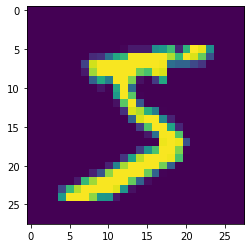

tensor(5)


In [136]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [137]:
'''
Когда мы работали с датасетом про вина, у нас каждая бутылка вина описывалася 13-ю признаками, 
и это был некоторый одномерный тензор, который соответствовал бутылке вина, и, соответственно, батч был двухмерным тензором. 
А здесь у нас немножко другая ситуация, когда у нас каждая картинка описывается двумерным тензором. Надо что-то с этим сделать. 
Я предлагаю растянуть эту картинку в один длинный вектор, и тогда каждый пиксель найдёт своё место в этом длинном векторе.
'''

X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [138]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons) # 28 * 28 = количество пикселей на входе
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

### Перевод вычислений на видеокарту

In [139]:
torch.cuda.is_available() # свободна ли сейчас видеокарточка

True

In [147]:
!nvidia-smi # более подробная инфа

Sat Jan 23 08:16:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    33W /  70W |   1477MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
'''
Какие же тензоры нам нужно переложить на видео карточку? 
Во-первых это веса нейронной сети -- это то, что будет оптимизироваться, 
это то, что участвует в вычислениях, это обязательно должно быть на видео карте. 
А кроме того нам нужно переложить на видео карту ещё и входы -- те картинки, которые мы передаём в нейросеть.
'''

# создать такую переменную "device", которая будет либо строчкой "cuda:0", 
# что соответствует нулевой видео-карточке (если у вас их вдруг много), либо "cpu", если видео-карты нету

# !!! runtime -> change runtime type
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
mnist_net = mnist_net.to(device) # перекидываем нейронку в девайс
list(mnist_net.parameters())     # список параметров на девайсе

In [142]:
'''
Нужно подчеркнуть, что функция CrossEntropyLoss на вход принимает не вероятности, 
а те выходы, которые до софтмакса, то есть функция forward, которую мы написали, 
не содержала софтмакс, потому что мы хотим немножко ускорить наши вычисления, избежав софтмакса. 
Для ускорения вычислений можно софтмакс и кроссэнтропию соединить одну функцию, 
и тогда будут немножко быстрее и стабильнее выполнять вычисления.
'''

loss = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [ ]:
'''
Мы будем обучаться батчевым или стохастическим градиентным спуском. 
То есть мы будем делить наш датасет на маленькие части (так называемые батчи), 
передавать эти батчи в нейронную сеть с помощью функции forward. 
После этого мы будем вызывать loss-функцию, которая скажет нам размер ошибки. 
После этого мы сможем посчитать градиент с помощью функции backward, 
и дальше мы сможем сделать градиентный шаг, вызвав optimizer.step.
'''

batch_size = 100

test_accuracy_history = [] # чтобы в будущем построить график
test_loss_history = []

X_test = X_test.to(device) # тестовые dataset перекидываем на видеокарту, а X_train 
y_test = y_test.to(device) # будет работать по батчам

for epoch in range(5):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device) # перекладываем батч на девайс
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test) # тестим нейронку каждую эпоху на test dataset
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean() # % правельных ответов

    # подставляем значения, чтобы ножно было проанализировать график
    test_loss_history.append(loss(test_preds, y_test))
    test_accuracy_history.append(accuracy)

    tmp = train_batch_loss_history[epoch * batch_size : (epoch + 1) * batch_size]
    train_loss_history.append()

    print(accuracy)

    
'''
Нейронная сеть предсказывает класс, для которого она выдает максимальное значение. 
То есть, после этого это значение отправляется в софтмакс, если нужно узнать его вероятность, 
но уже перед софтмаксом мы можем понять -- а какой наиболее вероятный класс предсказала нейронная сеть. 
Это будет тот нейрон, у которого максимальный выход.
Соответственно, нам нужно сделать argmax (argmax нам отдаст номер нейрона, 
одного из десяти, у которого максимальный выход), и сравнить это с y_test,
'''



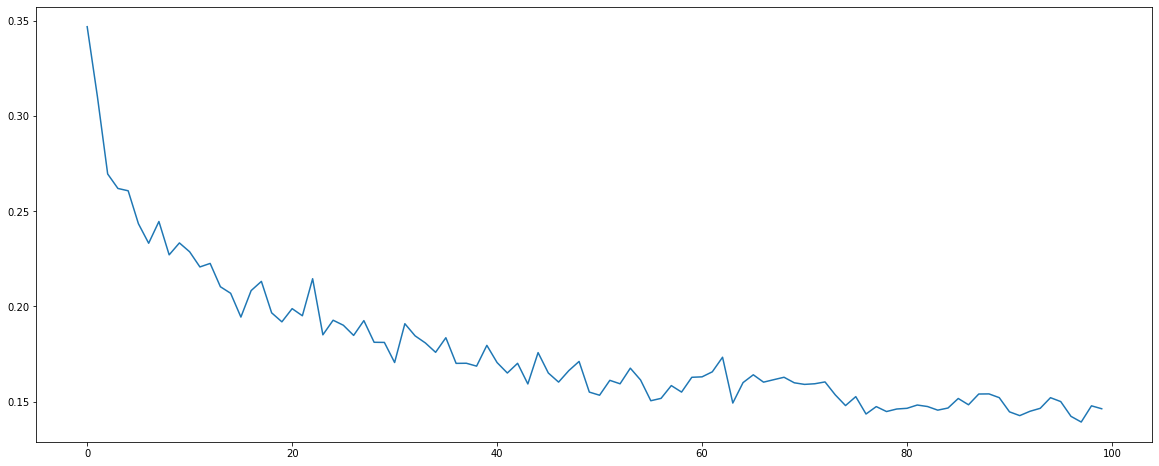

In [150]:
plt.figure(figsize=(20,8)) 
# plt.plot(test_accuracy_history)
plt.plot(test_loss_history)



'''
 Колебания в лоссе меньше, чем колебания в accuracy, потому что accuracy -- это уже округлённые значения, 
 а в loss учитываются вероятности, которые не так дискретны, 
 соответственно не дают таких жёстких колебаний на графике. 
 
 Кроме того, очень интересно смотреть на такие графики раздельно по train и по test, 
 то есть -- как улучшается качество на train, и как улучшается качество на test.
 Есть если вы видите что у вас качество на train растёт гораздо лучше, 
 если оно выходит на более высокие параметры в конце обучения, это значит, 
 что вы имеете дело с явлением переобучения и ваша нейронная сеть, вместо того, 
 чтобы выучивать какие-то новые вещи, она просто запоминает картинки. 
 И это можно побороть с помощью уменьшения параметров нейронной сети, уменьшения количества слоёв и уменьшения их размера.

'''